In [1]:
# imports
import torch
import torch.nn as nn  
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import BarycentricInterpolator
import scipy
import pandas as pd
import seaborn as sns
from torch.func import vmap, grad

# Test of the neural copula with the gradient pure

## Marginal

In [2]:
class MarginalModel(nn.Module):
    def __init__(self, num_layers=5, num_neurons=5, lr=0.01):
        super(MarginalModel, self).__init__()

        # Model specification
        layers = [nn.Linear(1, num_neurons), nn.Tanh()]  # Input layer
        for _ in range(num_layers - 1):  # Hidden layers
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_neurons, 1))  # Output layer
        layers.append(nn.Sigmoid())

        self.fc = nn.Sequential(*layers)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.batch_size = 128

        # Data for training
        self.ObservedData = None
        self.uniform_data = torch.tensor(np.linspace(0, 1, 500), dtype=torch.float32).view(-1, 1)
        self.lower_bound = torch.tensor([[0.0]]) 
        self.upper_bound = torch.tensor([[1.0]])

        ## For sampling
        self.domainUpper = torch.tensor([[1.0]])
        self.domainLower= torch.tensor([[0.0]])
        self.inverted = False
        self.inverseInterpolator = None

    def forward(self, x):
        return self.fc(x)

    def loss_function(self, x):
        x = x.detach().requires_grad_()
        self.uniform_data= self.uniform_data.detach().requires_grad_()
        y_pred = self(x)
        y_pred_uniform = self(self.uniform_data)
        dydx = torch.autograd.grad(y_pred, x, torch.ones_like(y_pred), create_graph=True)[0]
        dydx_uniform = torch.autograd.grad(y_pred_uniform, self.uniform_data, torch.ones_like(y_pred_uniform), create_graph=True)[0]

        L1 = -torch.mean(torch.log(torch.relu(dydx) + 1e-8))
        L2 = torch.mean(torch.relu(-dydx_uniform))
        L3 = torch.abs(1 - torch.sum(dydx_uniform)/self.uniform_data.shape[0])
        L4 = self(self.lower_bound) + torch.abs(1 - self(self.upper_bound))
        Loss = L1*0.001 + L2 + L3 +  L4
        return Loss , L1, L2, L3, L4


    def train_model(self, X, epochs=5000, log_interval=500):
        self.ObservedData = X

        # dataset = torch.utils.data.TensorDataset(X)
        # data_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        for epoch in range(epochs):
            #for batch_idx, (data,) in enumerate(data_loader):
                
            self.optimizer.zero_grad()
            loss, L1, L2, L3, L4 = self.loss_function(X)
            loss.backward()
            self.optimizer.step()

            if epoch % log_interval == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}, Constraint losses: L1: {L1.item()}, L2: {L2.item()}, L3: {L3.item()}, L4: {L4.item()}')

    def newSamples(self, ProbabilityValues = None, n = 1000): 
        # Sampling method that replaces the interpolator which struggles with values close to 0 and 1
        if ProbabilityValues is None:
            ProbabilityValues = np.random.uniform(0, 1, n)
        if torch.is_tensor(ProbabilityValues) == False:
            ProbabilityValues = torch.tensor(ProbabilityValues, dtype=torch.float32).view(-1, 1)
        sampledData = self._vectorized_bisection(ProbabilityValues).detach().numpy()
        return sampledData

    # def sample(self, n = 1000, ProbabilityValues = None): # Can sample only from marginal and with given probability values
    #     if self.inverted == False:
    #         print("Model not inverted. Inverting model...")
    #         self.inverseInterpolator = self._invertModel(asTensor=False)
    #         self.inverted = True

    #     if ProbabilityValues is None:
    #         ProbabilityValues = np.random.uniform(0, 1, n)
            
    #     # Generate random samples from a uniform distribution
    #     sampledData = self.inverseInterpolator(ProbabilityValues)
    #     return sampledData

    # def _invertModel(self, asTensor=True, plot=False):
    #     # Invert the model to get inverse CDF function
    #     rangeUpper = self(self.domainUpper)
    #     rangeLower= self(self.domainLower)
    #     # Generate Chebyshev nodes
    #     n = 3000
    #     rangePoints = self._chebyshev_nodes(n, rangeLower, rangeUpper).view(-1, 1)

    #     # use nodes to find inverses
    #     domainPoints = self._vectorized_bisection(rangePoints)

    #     # Add boundary points
    #     rangePoints = torch.cat((torch.tensor([0.0]), rangePoints.squeeze(), torch.tensor([1.0])))
    #     domainPoints = torch.cat((torch.tensor([0.0]), domainPoints.squeeze(), torch.tensor([1.0])))
    #     rangePoints_np = rangePoints.numpy()
    #     domainPoints_np = domainPoints.numpy()

    #     # Create interpolator
    #     interpolant = BarycentricInterpolator(rangePoints_np, domainPoints_np)
    #     interpolantTensor = lambda x: self._tensor_interpolant(x, interpolant) # interpolant using PyTorch tensors

    #     if plot:
    #         self.plotModel(model = interpolantTensor)
    #     if asTensor:
    #         return interpolantTensor
    #     else:
    #         return interpolant
        
    # def _tensor_interpolant(self, p_tensor, interpolant):
    #     """Interpolant function that takes PyTorch tensors as input."""
    #     p_numpy = p_tensor.detach().cpu().numpy()
    #     x_numpy = interpolant(p_numpy)
    #     return torch.tensor(x_numpy, dtype=torch.float32)

    def PlotModel(self):
        trainingData = self.ObservedData.detach().numpy()

        # # Generate x values for plotting
        x_points = np.linspace(0, 1, 100)
        x_plot =torch.tensor(x_points, dtype=torch.float32).view(-1, 1)
        x_plot.requires_grad = True  # Enable gradients for x_plot
        y_pred = self(x_plot)  # Keep y_pred in computation graph
        pdfPred = torch.autograd.grad(y_pred, x_plot, torch.ones_like(y_pred), create_graph=True)[0]

        ### Convert to numpy for plotting
        y_vals = y_pred.detach().numpy()
        grad_vals = pdfPred.detach().numpy()

        ### Plot the neural network approximation
        plt.plot(x_points, y_vals, label='CDF approximation', linestyle='dashed')
        ### Plot the derivative
        plt.plot(x_points, grad_vals, label="PDF Approximation", linestyle='solid')
        plt.hist(trainingData, bins=1000, density=True, alpha=0.6, label='True Distribution of data');
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('Density')
        plt.title('Neural Network Approximation of PDF and CDF ')
        plt.show()

    # def PlotInverse(self):
    #     if self.inverted == False:
    #         print("Model not inverted. Inverting model...")
    #         self.inverseInterpolator = self._invertModel(asTensor=False)
    #         self.inverted = True    
        
    #     x_points = np.linspace(0, 1, 1000)
    #     y_pred = self.inverseInterpolator(x_points)  
    #     #ChebyshovPoints = self._chebyshev_nodes(3000, 0, 1).numpy()
    #     plt.plot(x_points, y_pred, color='blue', label='Inverse CDF approximation')  # Blue line
    #     #plt.scatter(ChebyshovPoints, self.inverseInterpolator(ChebyshovPoints), color='red', label='Chebyshev nodes')  # Red points
    #     plt.xlabel('x')
    #     plt.ylabel('Inverse CDF')
    #     plt.title('Inverse CDF Approximation')
    #     plt.legend()
    #     plt.show()
        
    # def _chebyshev_nodes(self, n, a, b):
    #     """Generate n Chebyshev nodes in the interval [a, b]."""
    #     return torch.tensor([0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * k + 1) * np.pi / (2 * n)) for k in range(n)], dtype=torch.float32)

    def _vectorized_bisection(self, y, tol=1e-6, max_iter=100):
        """
        Vectorized Bisection Method to find roots of a function f(y) in the interval [0,1] for multiple values of y simultaneously.
        
        Parameters:
        f : function
            The function whose roots are to be found.
        y : torch.Tensor
            Tensor of values for which roots are to be found.
        tol : float, optional
            The tolerance for stopping the iteration (default is 1e-6).
        max_iter : int, optional
            Maximum number of iterations (default is 100).
        
        Returns:
        torch.Tensor
            Tensor of estimated root values.
        """
        a, b = torch.zeros_like(y), torch.ones_like(y)
        fa, fb = self(a) , self(b) 
        fa, fb = fa - y, fb - y
        
        for _ in range(max_iter):
            c = (a + b) / 2  # Midpoint
            fc = self(c) - y
            left_mask = fc * fa < 0
            right_mask = fc * fb < 0
            a, b = torch.where(left_mask, a, c), torch.where(right_mask, b, c)
            if torch.all(torch.abs(b - a) < tol):
                break
        return (a + b) / 2



## Copula 

In [151]:
# torch.manual_seed(0)
class CopulaModel(nn.Module):
    def __init__(self, dataPoints, Marginal1, Marginal2, num_layers=5, num_neurons=5, lr=0.01):
        super(CopulaModel, self).__init__()
        dimensions = dataPoints.size(1)
        layers = [nn.Linear(dimensions, num_neurons), nn.Tanh()]  # Input layer
        for _ in range(num_layers - 1):  # Hidden layers
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_neurons, 1))  # Output layer
        layers.append(nn.Sigmoid())

        self.fc = nn.Sequential(*layers)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        ### Data for training
        self.ObservedData = dataPoints
        self.Marginal1 = Marginal1
        self.Marginal2 = Marginal2

        ## TRANSFORMING DATA TO UNIT SQUARE
        x1 = self.ObservedData[:,0]
        x2 = self.ObservedData[:,1]
        # Probability integral transform
        ProbVals1 = self.Marginal1(x1.view(-1, 1))
        ProbVals2 = self.Marginal2(x2.view(-1, 1))
        self.u = torch.cat((ProbVals1, ProbVals2), dim=1)
        #self.u.requires_grad = True
        # Boundary points
        self.upperBoundary = self._generateUpperBoundaryPoints(dimensions)
        self.lowerBoundary = self._generateLowerBoundPoints(dimensions)
        # Uniform grid points
        u= np.linspace(0.0, 1.0, 50)
        U1, U2 = np.meshgrid(u, u, indexing="ij")
        unitSquarePoints= np.column_stack((U1.ravel(), U2.ravel()))
        self.unitSquaretensor = torch.tensor(unitSquarePoints, dtype=torch.float32)

        # Look at later
        self.flagSumData = self._FlagSum(self.unitSquaretensor, self.u)/ self.u.shape[0]
        self.delta_m = 1 / dataPoints.shape[0]

        # Practicality
        self.isTrained = False

    def forward(self, x):
        return self.fc(x)

    # def _CopulaGradient(self,x):
    #     x1 = x[:,0]
    #     x2 = x[:,1]
    #     # Probability integral transform
    #     ProbVals1 = self.Marginal1(x1.view(-1, 1))
    #     ProbVals2 = self.Marginal2(x2.view(-1, 1))
    #     u = torch.cat((ProbVals1, ProbVals2), dim=1)
    #     # Calculate marginal densities
    #     gradM1 = torch.autograd.grad(ProbVals1, x1, torch.ones_like(ProbVals1), create_graph=True, allow_unused=True)[0]
    #     gradM2 = torch.autograd.grad(ProbVals2, x2, torch.ones_like(ProbVals2), create_graph=True, allow_unused=True )[0]
    #     # Prediction and gradient of copula CDF
    #     y_pred = self(u)
    #     gradCopulaModel = torch.autograd.grad(y_pred, u, torch.ones_like(y_pred), create_graph=True, allow_unused=True )[0]
    #     CopulaGradient = gradCopulaModel[:, 0] * gradM1 * gradCopulaModel[:, 1] * gradM2
    #     return CopulaGradient

    def Copula_loss_function(self, x): ## MAKE SURE TO PASS IN THE SAME DATAPOINTS AS IN THE INITIALIZATION
        x.requires_grad = True  ## X is the untransformed data points
        self.unitSquaretensor.requires_grad = True ## evenly distributed points in the unit square

        ## gradient for observed data points
        y_pred = self(self.u)
        gradOBS = torch.autograd.grad(outputs=y_pred ,inputs=self.u ,grad_outputs=torch.ones_like(y_pred),create_graph=True)[0]  ## first partial derivatives 
        cross_derivativeOBS = torch.autograd.grad(outputs=gradOBS[:, 0], inputs=self.u, grad_outputs=torch.ones_like(gradOBS[:, 0]),retain_graph=True)[0][:, 1]  # derivative of dC/du1 with respect to u2
        CopulaGradientObserved = cross_derivativeOBS 
        n_observed = x.shape[0]


        ## gradient for unit square points
        pred_unitSquare = self(self.unitSquaretensor)
        gradUNIF = torch.autograd.grad(outputs=pred_unitSquare ,inputs=self.unitSquaretensor ,grad_outputs=torch.ones_like(pred_unitSquare),create_graph=True)[0]  ## first partial derivatives 
        cross_derivativeUNIF = torch.autograd.grad(outputs=gradUNIF[:, 0], inputs=self.unitSquaretensor, grad_outputs=torch.ones_like(gradUNIF[:, 0]),retain_graph=True)[0][:, 1]  # derivative of dC/du1 with respect to u2
        CopulaGradientUnitSquare = cross_derivativeUNIF
        n_unitsquare = self.unitSquaretensor.shape[0]

        
        
        L1 = -torch.mean(torch.log(torch.relu(CopulaGradientObserved) + 1e-8))
        L2 = torch.mean(torch.relu(-CopulaGradientUnitSquare))
        L3 = torch.abs(1 - torch.sum(CopulaGradientUnitSquare / CopulaGradientUnitSquare.shape[0]))
        L4 = torch.sum(self(self.lowerBoundary)) + torch.sum(torch.abs(self(self.upperBoundary) - torch.min(self.upperBoundary, dim=1).values.view(-1,1)))      
        L5 = (1/(n_unitsquare)) * torch.sum(torch.abs(pred_unitSquare.squeeze() - self.flagSumData)) 


        Loss = L1 + L2 + L3 + 0.1*L4 #+ L5
        return Loss, L1, L2, L3, L4, L5
    
# #a = _FlagSum(uniform, observed)/observed.shape[0]
# unit = copula.unitSquaretensor
# C_unit = copula(unit) #(100, 1)
# Flagsum = copula.flagSumData ## (100)

# diff = torch.mean(torch.abs(C_unit.squeeze() - Flagsum) )##(100,100)

    def _generateLowerBoundPoints(self, d, num_points=100):
        grid = np.linspace(0, 1, num_points)
        all_surfaces = []
        for k in range(d):
            grid_points = np.meshgrid(*([grid] * (d - 1)), indexing="ij")
            points = np.stack(grid_points, axis=-1).reshape(-1, d - 1)
            surface_points = np.insert(points, k, 0, axis=1)
            all_surfaces.append(surface_points)
        return torch.tensor(np.vstack(all_surfaces), dtype=torch.float32)

    def _generateUpperBoundaryPoints(self, d, num_points=100):
        oneArray = np.ones((d * num_points, d))
        u = np.linspace(0, 1, num_points)
        for i in range(d):
            oneArray[i * num_points:(i + 1) * num_points, i] = u
        return torch.tensor(oneArray, dtype=torch.float32)

    def _flag(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Vectorized version of _flag that returns a matrix where each element is a comparison result."""
        return torch.all(y.unsqueeze(0) < x.unsqueeze(1), dim=2).float()

    def _FlagSum(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Vectorized computation of FlagSum without explicit Python loops."""
        return self._flag(x, y).sum(dim=1)

    def train_model(self, X, epochs=5000, log_interval=500):
            for epoch in range(epochs):
                self.optimizer.zero_grad()
                loss, L1, L2, L3, L4, L5 = self.Copula_loss_function(X)
                loss.backward()
                self.optimizer.step()

                if epoch % log_interval == 0:
                    print(f'Epoch {epoch}, Loss: {loss.item()}, Losses: L1: {L1.item()}, L2: {L2.item()}, L3: {L3.item()}, L4: {L4.item()}, L5: {L5.item()}')

            self.isTrained = True

    def sample(self, n=1000):
            if not self.isTrained:
                print("Model not trained. Training model...")
                self.train_model(self.ObservedData)
            # Build the grid to compute M
            dim_range = torch.linspace(0, 1, 1000)
            grid = torch.stack(torch.meshgrid(dim_range, dim_range, indexing='ij'), dim=-1).flatten(0, 1).requires_grad_()
            C_uv = self(grid)
            grad_u = torch.autograd.grad(C_uv, grid, torch.ones_like(C_uv), create_graph=True)[0][:, 0]
            grad_uv = torch.autograd.grad(grad_u, grid, torch.ones_like(grad_u), create_graph=True)[0][:, 1]
            M = grad_uv.max().item()

            # Initialize empty list to collect samples
            accepted_samples = []
            total_accepted = 0

            # While not enough samples
            while total_accepted < n:
                # Propose candidates
                batch_size = 1*n  
                u1 = torch.rand(batch_size, 1)
                u2 = torch.rand(batch_size, 1)
                u = torch.cat((u1, u2), dim=1).requires_grad_(True)

                # Forward pass
                y_pred = self(u)
                grad_u1 = torch.autograd.grad(y_pred, u, torch.ones_like(y_pred), create_graph=True)[0][:, 0]
                grad_u1_u2 = torch.autograd.grad(grad_u1, u, torch.ones_like(grad_u1), create_graph=True)[0][:, 1]
                acceptance_prob = grad_u1_u2 / M
                random_uniform = torch.rand_like(acceptance_prob)
                accepted_batch = u[random_uniform <= acceptance_prob]


                total_accepted += accepted_batch.shape[0]
                print(f'Accepted: {total_accepted}')
                accepted_samples.append(accepted_batch)

            # Concatenate all accepted batches
            accepted_samples = torch.cat(accepted_samples, dim=0)

            # Only keep exactly n samples
            accepted_samples = accepted_samples[:n]
            return accepted_samples
    
    def plotSamples(self, sample, ProbSpace = True):
        df_samples = pd.DataFrame({
        "U1": sample[:,0].flatten(),  
        "U2": sample[:,1].flatten()
        })
        sns.jointplot(
            data=df_samples, x="U1", y="U2", kind="scatter",
            marginal_kws=dict(bins=30, fill=True),
            joint_kws={"s": 10, "edgecolor": "none"}  # Removes white outline
        )
        if ProbSpace:
            plt.suptitle("Sampled data in probability space", y=1.02);  
        else:
            plt.suptitle("Sampled data in return space", y=1.02);
        plt.show()
        pass




## Generate data and scale right 

In [97]:
## Creating data
corrMat = np.array([[1, 0.], [0., 1]])
A = np.linalg.cholesky(corrMat)
np.random.seed(0)
Z = np.random.standard_normal((2000, 2))
X = (A @ Z.T).T

## Normalizing data to create marginals
scaling = 2.0
Z_squashed = np.zeros((Z.shape[0]+2, Z.shape[1]))
for i in range(X.shape[1]):
    boundaryPoints = scaling * np.array([np.max(Z[:,i]), np.min(Z[:,i])]) # Creates points for bounds of what the data generated can be
    Z_added = np.concatenate((Z[:,i], boundaryPoints)) # Adding boundary points to the data
    Z_squashed[:,i] = (Z_added - np.min(Z_added)) / (np.max(Z_added) - np.min(Z_added)) # Normalizing the data

# Create tensor
X = torch.tensor(Z_squashed, dtype=torch.float32)

## Marginal training

In [98]:
# Initialize and train the model with custom layers and neurons
Marginal1 = MarginalModel(num_layers=6, num_neurons=10, lr=0.01)
Marginal2 = MarginalModel(num_layers=6, num_neurons=10, lr=0.01)
print('Model 1 Training')
Marginal1.train_model(X[:-2,0].view(-1, 1), epochs=2000, log_interval=500)
print('Model 2 Training')
Marginal2.train_model(X[:-2,1].view(-1, 1), epochs=2000, log_interval=500)

Model 1 Training
Epoch 0, Loss: 2.0481486320495605, Constraint losses: L1: 18.42068099975586, L2: 0.009909040294587612, L3: 1.0099090337753296, L4: 1.0099098682403564
Epoch 500, Loss: 0.001739452825859189, Constraint losses: L1: -1.3035409450531006, L2: 0.0, L3: 0.0025208592414855957, L4: 0.000522134592756629
Epoch 1000, Loss: 0.001030936953611672, Constraint losses: L1: -1.311425805091858, L2: 0.0, L3: 0.0021709799766540527, L4: 0.0001713828241918236
Epoch 1500, Loss: 0.0008604152244515717, Constraint losses: L1: -1.3114430904388428, L2: 0.0, L3: 0.0020858049392700195, L4: 8.605343464296311e-05
Model 2 Training
Epoch 0, Loss: 2.0016281604766846, Constraint losses: L1: 6.073265552520752, L2: 0.0, L3: 0.9977775812149048, L4: 0.9977772831916809
Epoch 500, Loss: 0.002272107871249318, Constraint losses: L1: -1.1117126941680908, L2: 0.0, L3: 0.0026908516883850098, L4: 0.0006929690134711564
Epoch 1000, Loss: 0.0012133457930758595, Constraint losses: L1: -1.2114286422729492, L2: 0.0, L3: 0.00

## Copula training

In [152]:
# Initialize and train the copula model
print(f'Iteration/seed {1}')
torch.manual_seed(3)
print('Training copula model')
copula = CopulaModel(X[:-2], Marginal1, Marginal2, num_layers=5, num_neurons=20, lr=0.001)
copula.train_model(X[:-2], epochs=5000, log_interval=500)
#sample = copula.sample()

Iteration/seed 1
Training copula model
Epoch 0, Loss: 34.633758544921875, Losses: L1: 18.42068099975586, L2: 0.0014863082906231284, L3: 1.0014863014221191, L4: 152.10107421875, L5: 0.30777987837791443
Epoch 500, Loss: 4.154363632202148, Losses: L1: 3.3540167808532715, L2: 0.1562003195285797, L3: 0.18727314472198486, L4: 4.5687360763549805, L5: 0.08195317536592484
Epoch 1000, Loss: 6.290658950805664, Losses: L1: 5.818150520324707, L2: 0.18203535676002502, L3: 0.12230682373046875, L4: 1.6816635131835938, L5: 0.08148542046546936
Epoch 1500, Loss: 7.583254814147949, Losses: L1: 7.236965656280518, L2: 0.12948103249073029, L3: 0.10407876968383789, L4: 1.127293348312378, L5: 0.08169025927782059
Epoch 2000, Loss: 7.755277633666992, Losses: L1: 7.438008785247803, L2: 0.15245622396469116, L3: 0.0855180025100708, L4: 0.7929455041885376, L5: 0.08208326995372772
Epoch 2500, Loss: 7.8268327713012695, Losses: L1: 7.435246467590332, L2: 0.20019203424453735, L3: 0.07540905475616455, L4: 1.1598515510559

## Visualization

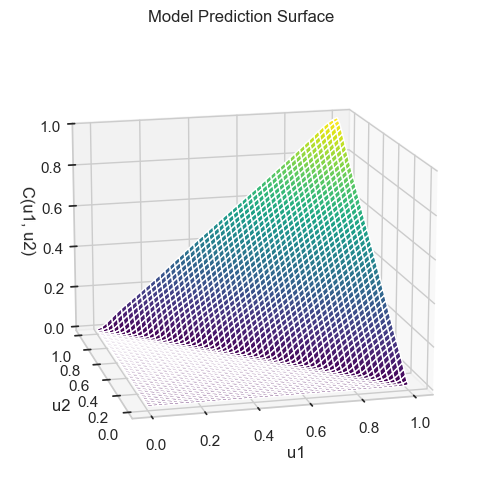

In [153]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid
u1 = np.linspace(0, 1, 500)
u2 = np.linspace(0, 1, 500)
U1, U2 = np.meshgrid(u1, u2, indexing="ij")
grid = np.column_stack((U1.ravel(), U2.ravel()))
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# # Get model predictions
# copula.eval()
# with torch.no_grad():
#     predictions = copula(grid_tensor)
# Z = predictions.numpy().reshape(500, 500)  


Z = copula(grid_tensor).detach().numpy().reshape(500, 500)  

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(U1, U2, Z, cmap="viridis")
ax.set_xlabel("u1")
ax.set_ylabel("u2")
ax.set_zlabel("C(u1, u2)")
ax.set_title("Model Prediction Surface")
ax.view_init(elev=15, azim=256)
plt.show()


## Gradient visualization

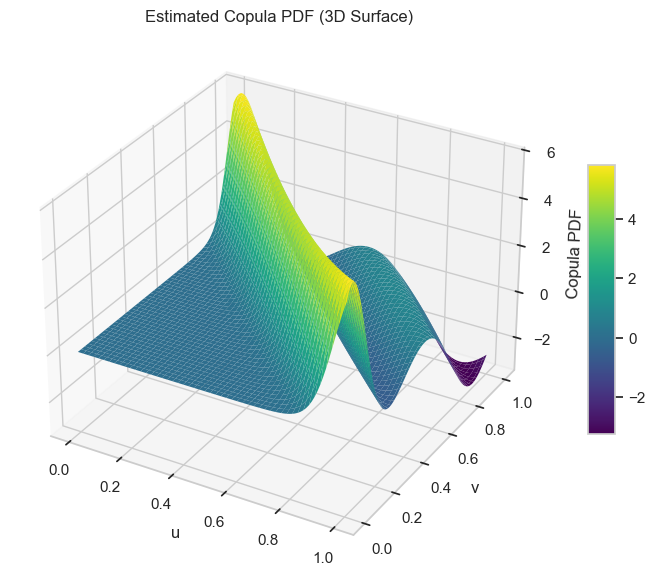

In [115]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
import numpy as np

# Generate grid over [0,1] x [0,1]
n = 100
u_vals = torch.linspace(0, 1, n)
v_vals = torch.linspace(0, 1, n)
uu, vv = torch.meshgrid(u_vals, v_vals, indexing='ij')
grid = torch.stack([uu.flatten(), vv.flatten()], dim=1).requires_grad_(True)

# Compute C(u,v)
C_uv = copula(grid)  # Output should be shape [N] or [N, 1]

# ∂C/∂u
grad_u = torch.autograd.grad(C_uv, grid, grad_outputs=torch.ones_like(C_uv), create_graph=True)[0][:, 0]

# ∂²C/∂u∂v = ∂(∂C/∂u)/∂v
grad_uv = torch.autograd.grad(grad_u, grid, grad_outputs=torch.ones_like(grad_u), create_graph=True)[0][:, 1]

# Reshape for plotting
pdf_values = grad_uv.detach().numpy().reshape(n, n)

# Convert uu, vv to numpy
uu_np = uu.numpy()
vv_np = vv.numpy()

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(uu_np, vv_np, pdf_values, cmap='viridis', edgecolor='none')

ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('Copula PDF')
ax.set_title('Estimated Copula PDF (3D Surface)')
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


In [ ]:

# import torch
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Create example datasets
# observed = torch.tensor([
#     [0.33, 0.33],
#     [0.33, 0.5],
#     [0.33, 0.66],
#     [0.5, 0.33],
#     [0.5, 0.5],
#     [0.5, 0.66],
#     [0.66, 0.33],
#     [0.66, 0.5],
#     [0.66, 0.66],
# ], dtype=torch.float) ## observed

# uniform = torch.tensor([
#     [0., 0.],
# ], dtype=torch.float) ## generated

# # Compute _flag and _FlagSum
# def _flag(x, y):
#     return torch.all(y.unsqueeze(0) < x.unsqueeze(1), dim=2).float()

# def _FlagSum(x, y):
#     return _flag(x, y).sum(dim=1)

# a = _FlagSum(uniform, observed)/observed.shape[0]



# # flag_matrix = _flag(x, y)
# # flag_sum = _FlagSum(x, y)

# # print("Flag matrix (_flag(x, y)):\n", flag_matrix)
# # print("\nFlag sum (_FlagSum(x, y)):\n", flag_sum)

# # # --------- PLOT THE DATA ---------

# # # Set plot style
# # sns.set(style="whitegrid")
# # plt.figure(figsize=(8, 6))

# # # Plot x points
# # plt.scatter(x[:,0], x[:,1], color='blue', label='x points', s=100, marker='o')
# # for i, coord in enumerate(x):
# #     plt.text(coord[0]+0.1, coord[1], f"x[{i}]", color='blue')

# # # Plot y points
# # plt.scatter(y[:,0], y[:,1], color='red', label='y points', s=100, marker='^')
# # for j, coord in enumerate(y):
# #     plt.text(coord[0]+0.1, coord[1], f"y[{j}]", color='red')

# # plt.xlabel("X1")
# # plt.ylabel("X2")
# # plt.title("Datasets x and y")
# # plt.legend()
# # plt.grid(True)
# # plt.show()

# # # --------- PLOT THE FLAG MATRIX ---------
# # plt.figure(figsize=(6, 4))
# # sns.heatmap(flag_matrix.numpy(), annot=True, cmap="YlGnBu", cbar=False)
# # plt.title("_flag(x, y) Matrix")
# # plt.xlabel("y points")
# # plt.ylabel("x points")
# # plt.show()

# # # --------- PLOT THE FLAG SUM ---------
# # plt.figure(figsize=(6, 4))
# # plt.bar(range(len(flag_sum)), flag_sum.numpy(), color='skyblue')
# # plt.title("_FlagSum(x, y)")
# # plt.xlabel("x points (index)")
# # plt.ylabel("Number of y points less than x[i]")
# # plt.grid(True)
# # plt.show()




In [ ]:
# def _flag( x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
#     """Vectorized version of _flag that returns a matrix where each element is a comparison result."""
#     return torch.all(y.unsqueeze(0) < x.unsqueeze(1), dim=2).float()

# def _FlagSum( x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
#     """Vectorized computation of FlagSum without explicit Python loops."""
#     return _flag(x, y).sum(dim=1)

# # Create example datasets
# observed = torch.tensor([
#     [0.33, 0.33],
#     [0.33, 0.5],
#     [0.33, 0.66],
#     [0.5, 0.33],
#     [0.5, 0.5],
#     [0.5, 0.66],
#     [0.66, 0.33],
#     [0.66, 0.5],
#     [0.66, 0.66],
# ], dtype=torch.float) ## observed

# uniform = torch.tensor([
#     [0., 0.],
#     [0.5, 0.5],
#     [0.9, 0.9]
# ], dtype=torch.float) ## generated

# # Compute _flag and _FlagSum
# # def _flag(x, y):
# #     return torch.all(y.unsqueeze(0) < x.unsqueeze(1), dim=2).float()

# # def _FlagSum(x, y):
# #     return _flag(x, y).sum(dim=1)

# a = _FlagSum(uniform, observed)/observed.shape[0]
